# Recruit restaurant competition

## Some thoughts about tasks
* Convert dates and times
* Summarise tables: one row per restaurant and day
* Join with store info
* Join with actual air visit data
* Join with holidays data
* Think about what to do with hpg data...

Remember any features extracted from training tables need to be extractable from submission table.

Remember that we are predicting visits, not reservations.

Check if we have reservation data for some or all submission dates.

Check if the restaurants in the submission list are all included in the training data.

## Loading modules

In [86]:
import pandas as pd
import sklearn as sk

## Loading raw data

In [87]:
air_reserve = pd.read_csv('input/air_reserve.csv')
air_store_info = pd.read_csv('input/air_store_info.csv')
air_visit_data = pd.read_csv('input/air_visit_data.csv')
hpg_reserve = pd.read_csv('input/hpg_reserve.csv')
hpg_store_info = pd.read_csv('input/hpg_store_info.csv')
date_info = pd.read_csv('input/date_info.csv')
sample_submission = pd.read_csv('input/sample_submission.csv')
store_id_relation = pd.read_csv('input/store_id_relation.csv')

### Checking submission samples
What's interesting is that predictions are only required for places in the "air" booking system. Thus, how should we use HPG infos?

In [88]:
sample_submission.sort_values('id').tail()

,id,visitors
32014,air_fff68b929994bfbd_2017-05-27,0
32015,air_fff68b929994bfbd_2017-05-28,0
32016,air_fff68b929994bfbd_2017-05-29,0
32017,air_fff68b929994bfbd_2017-05-30,0
32018,air_fff68b929994bfbd_2017-05-31,0


### A look at date_info table
Good news: seems like we get the holiday info for every date in the submission table.

In [89]:
date_info.tail()

,calendar_date,day_of_week,holiday_flg
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
516,2017-05-31,Wednesday,0


## Data transformation

### Extract info from dates
First, define a little function to extract year, month, day, hour

In [90]:
def extract_dates(pd_df, target_var, format_str="%Y-%m-%d %H:%M:%S", prefix=None):
    if not prefix:
        prefix = target_var
    pd_df[target_var] = pd.to_datetime(pd_df[target_var], format=format_str)
    pd_df['{0}_year'.format(prefix)]  = pd.DatetimeIndex(pd_df[target_var]).year
    pd_df['{0}_month'.format(prefix)] = pd.DatetimeIndex(pd_df[target_var]).month
    pd_df['{0}_day'.format(prefix)]   = pd.DatetimeIndex(pd_df[target_var]).day
    pd_df['{0}_weekday'.format(prefix)]   = pd.DatetimeIndex(pd_df[target_var]).weekday
    pd_df['{0}_hour'.format(prefix)]  = pd.DatetimeIndex(pd_df[target_var]).hour
    pd_df.drop(target_var, inplace=True, axis=1)
    return pd_df

#### Extract date infos from hpg_reserve

In [91]:
hpg_reserve = extract_dates(pd_df = hpg_reserve, target_var = 'visit_datetime', prefix='target')
hpg_reserve = extract_dates(pd_df = hpg_reserve, target_var = 'reserve_datetime')
hpg_reserve.head()

,hpg_store_id,reserve_visitors,target_year,target_month,target_day,target_weekday,target_hour,reserve_datetime_year,reserve_datetime_month,reserve_datetime_day,reserve_datetime_weekday,reserve_datetime_hour
0,hpg_c63f6f42e088e50f,1,2016,1,1,4,11,2016,1,1,4,9
1,hpg_dac72789163a3f47,3,2016,1,1,4,13,2016,1,1,4,6
2,hpg_c8e24dcf51ca1eb5,2,2016,1,1,4,16,2016,1,1,4,14
3,hpg_24bb207e5fd49d4a,5,2016,1,1,4,17,2016,1,1,4,11
4,hpg_25291c542ebb3bc2,13,2016,1,1,4,17,2016,1,1,4,3


#### Now air reservations

In [92]:
air_reserve = extract_dates(pd_df = air_reserve, target_var = 'visit_datetime', prefix='target')
air_reserve = extract_dates(pd_df = air_reserve, target_var = 'reserve_datetime')
air_reserve.pivot_table(columns='reserve_datetime_weekday')

reserve_datetime_weekday,0,1,2,3,4,5,6
reserve_datetime_day,16.150203,15.994182,14.879658,14.743219,15.309101,15.273579,15.644157
reserve_datetime_hour,17.037157,16.793863,16.767664,16.802785,16.423291,15.854328,15.795848
reserve_datetime_month,5.654972,5.598601,5.530238,5.555461,5.500857,5.372820,5.540127
reserve_datetime_year,2016.460977,2016.476138,2016.491957,2016.494582,2016.488581,2016.506702,2016.486103
reserve_visitors,4.759144,4.793032,4.634290,4.526762,4.390988,3.977955,4.123563
target_day,16.387161,16.476138,15.985543,16.036645,16.128043,16.063953,16.401607
target_hour,18.194576,18.117268,18.125365,18.110593,18.087511,17.932817,17.648510
target_month,5.663515,5.580453,5.490871,5.511920,5.446334,5.328569,5.535328
target_weekday,2.323878,2.812703,3.218353,3.581598,3.846993,4.299822,4.086840
target_year,2016.487020,2016.501558,2016.515509,2016.516845,2016.510459,2016.525517,2016.508092


#### Now dateinfo

In [93]:
date_info = extract_dates(pd_df = date_info, target_var = 'calendar_date', format_str="%Y-%m-%d", prefix='date')
date_info.drop('date_hour', inplace=True, axis=1)
date_info.pivot_table(columns='day_of_week')

day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
date_day,15.567568,15.675676,15.743243,15.918919,15.602740,15.864865,15.648649
date_month,5.513514,5.445946,5.540541,5.405405,5.547945,5.472973,5.513514
date_weekday,4.000000,0.000000,5.000000,6.000000,3.000000,1.000000,2.000000
date_year,2016.283784,2016.297297,2016.283784,2016.297297,2016.287671,2016.297297,2016.297297
holiday_flg,0.067568,0.121622,0.067568,0.054054,0.095890,0.027027,0.040541


### Extract dates and location from submission table

In [94]:
# GR NOTE: If this is simply an example submission, this cell can be removed.
# First, split up id column
x = sample_submission.join(sample_submission['id'].str.split('_', 1, expand=True).rename(columns={0:'id1', 1:'id2'}))
x['id2'], x['date'] = x['id2'].str.split('_', 1).str
x['air_store_id'] = x[['id1', 'id2']].apply(lambda x: '_'.join(x), axis=1)
x.rename(columns={'id1':'store_type'}, inplace=True)
x.drop('id2', inplace=True, axis=1)
x = extract_dates(pd_df = x, target_var = 'date', format_str="%Y-%m-%d", prefix='target')
x.drop('target_hour', inplace=True, axis=1)
x['test'] = 1
x.head()
sample_submission = x
sample_submission.head()

,id,visitors,store_type,air_store_id,target_year,target_month,target_day,target_weekday,test
0,air_00a91d42b08b08d9_2017-04-23,0,air,air_00a91d42b08b08d9,2017,4,23,6,1
1,air_00a91d42b08b08d9_2017-04-24,0,air,air_00a91d42b08b08d9,2017,4,24,0,1
2,air_00a91d42b08b08d9_2017-04-25,0,air,air_00a91d42b08b08d9,2017,4,25,1,1
3,air_00a91d42b08b08d9_2017-04-26,0,air,air_00a91d42b08b08d9,2017,4,26,2,1
4,air_00a91d42b08b08d9_2017-04-27,0,air,air_00a91d42b08b08d9,2017,4,27,3,1


In [95]:
sample_submission.pivot_table(columns='store_type')

store_type,air
target_day,18.153846
target_month,4.794872
target_weekday,2.923077
target_year,2017.000000
test,1.000000
visitors,0.000000


### Extract date info from air_visit_data

In [96]:
air_visit_data = extract_dates(pd_df = air_visit_data, target_var = 'visit_date', 
                               format_str="%Y-%m-%d", prefix='target')
air_visit_data.drop('target_hour', axis=1, inplace=True)
air_visit_data['id'] = 0
air_visit_data['test'] = 0
air_visit_data['store_type'] = 'air'
air_visit_data.head()

,air_store_id,visitors,target_year,target_month,target_day,target_weekday,id,test,store_type
0,air_ba937bf13d40fb24,25,2016,1,13,2,0,0,air
1,air_ba937bf13d40fb24,32,2016,1,14,3,0,0,air
2,air_ba937bf13d40fb24,29,2016,1,15,4,0,0,air
3,air_ba937bf13d40fb24,22,2016,1,16,5,0,0,air
4,air_ba937bf13d40fb24,6,2016,1,18,0,0,0,air


### Constructing main table
Concatenate edited submission table with air_visit_data

In [97]:
main_tbl = pd.concat([air_visit_data, sample_submission])
main_tbl.head()

,air_store_id,id,store_type,target_day,target_month,target_weekday,target_year,test,visitors
0,air_ba937bf13d40fb24,0,air,13,1,2,2016,0,25
1,air_ba937bf13d40fb24,0,air,14,1,3,2016,0,32
2,air_ba937bf13d40fb24,0,air,15,1,4,2016,0,29
3,air_ba937bf13d40fb24,0,air,16,1,5,2016,0,22
4,air_ba937bf13d40fb24,0,air,18,1,0,2016,0,6


In [98]:
main_tbl.pivot_table(columns='test')

test,0,1
target_day,15.591830,18.153846
target_month,6.208200,4.794872
target_weekday,3.019678,2.923077
target_year,2016.307697,2017.000000
visitors,20.973761,0.000000


## Prepare baseline submission
Ie. average number of visitors for each restaurant.

In [99]:
def prepare_submission(main_tbl, fpath=None):
    sub_tbl = main_tbl.loc[main_tbl['test'] == 1][['id', 'visitors']]
    if fpath:
        sub_tbl.to_csv(fpath, index=False)
    return sub_tbl

In [100]:
# Get mean visitor numbers for train data
visitors_mean = main_tbl.loc[main_tbl['test'] == 0].visitors.mean()
baseline_sub = main_tbl.loc[main_tbl['test'] == 1][['id', 'visitors']]
baseline_sub.visitors = visitors_mean
baseline_sub.to_csv('submissions/baseline.csv', index=False)

## Merge with additional infos

### Merge with store info

In [101]:
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [102]:
main_tbl_merge = pd.merge(main_tbl, air_store_info, on='air_store_id')
main_tbl_merge.head()

,air_store_id,id,store_type,target_day,target_month,target_weekday,target_year,test,visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,0,air,13,1,2,2016,0,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,0,air,14,1,3,2016,0,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,0,air,15,1,4,2016,0,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,0,air,16,1,5,2016,0,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,0,air,18,1,0,2016,0,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [103]:
main_tbl_merge.describe()

,target_day,target_month,target_weekday,target_year,test,visitors,latitude,longitude
count,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000
mean,15.880550,6.048929,3.008792,2016.385715,0.112693,18.610174,35.615446,137.363917
std,8.756654,3.498014,1.937996,0.486765,0.316217,17.121342,2.046084,3.668228
min,1.000000,1.000000,0.000000,2016.000000,0.000000,0.000000,33.211967,130.195555
25%,8.000000,3.000000,1.000000,2016.000000,0.000000,6.000000,34.692337,135.341564
50%,16.000000,5.000000,3.000000,2016.000000,0.000000,15.000000,35.658068,139.671958
75%,23.000000,9.000000,5.000000,2017.000000,0.000000,27.000000,35.694003,139.751599
max,31.000000,12.000000,6.000000,2017.000000,1.000000,877.000000,44.020632,144.273398


### Merge with holiday info

In [104]:
date_info_merge = date_info
date_info_merge['date_id'] = date_info_merge[['date_year', 'date_month', 'date_day']].astype(str).apply(lambda x: '_'.join((x)), axis=1)
date_info_merge = date_info_merge[['holiday_flg', 'date_id']]
date_info_merge.head()

,holiday_flg,date_id
0,1,2016_1_1
1,1,2016_1_2
2,1,2016_1_3
3,0,2016_1_4
4,0,2016_1_5


In [105]:
main_tbl_merge2 = main_tbl_merge
main_tbl_merge2['date_id'] = main_tbl_merge2[['target_year', 'target_month', 'target_day']].astype(str).apply(lambda x: '_'.join((x)), axis=1)

main_tbl_merge2.head()

,air_store_id,id,store_type,target_day,target_month,target_weekday,target_year,test,visitors,air_genre_name,air_area_name,latitude,longitude,date_id
0,air_ba937bf13d40fb24,0,air,13,1,2,2016,0,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016_1_13
1,air_ba937bf13d40fb24,0,air,14,1,3,2016,0,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016_1_14
2,air_ba937bf13d40fb24,0,air,15,1,4,2016,0,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016_1_15
3,air_ba937bf13d40fb24,0,air,16,1,5,2016,0,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016_1_16
4,air_ba937bf13d40fb24,0,air,18,1,0,2016,0,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016_1_18


In [106]:
main_tbl_merge = pd.merge(left=main_tbl_merge2, right=date_info_merge, on='date_id')
main_tbl_merge.describe()

,target_day,target_month,target_weekday,target_year,test,visitors,latitude,longitude,holiday_flg
count,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000,284127.000000
mean,15.880550,6.048929,3.008792,2016.385715,0.112693,18.610174,35.615446,137.363917,0.056520
std,8.756654,3.498014,1.937996,0.486765,0.316217,17.121342,2.046084,3.668228,0.230924
min,1.000000,1.000000,0.000000,2016.000000,0.000000,0.000000,33.211967,130.195555,0.000000
25%,8.000000,3.000000,1.000000,2016.000000,0.000000,6.000000,34.692337,135.341564,0.000000
50%,16.000000,5.000000,3.000000,2016.000000,0.000000,15.000000,35.658068,139.671958,0.000000
75%,23.000000,9.000000,5.000000,2017.000000,0.000000,27.000000,35.694003,139.751599,0.000000
max,31.000000,12.000000,6.000000,2017.000000,1.000000,877.000000,44.020632,144.273398,1.000000


### Save current stage to disk

In [107]:
main_tbl_merge.to_csv('output/main_tbl.csv')
model_data = main_tbl_merge

## Plotting correlations

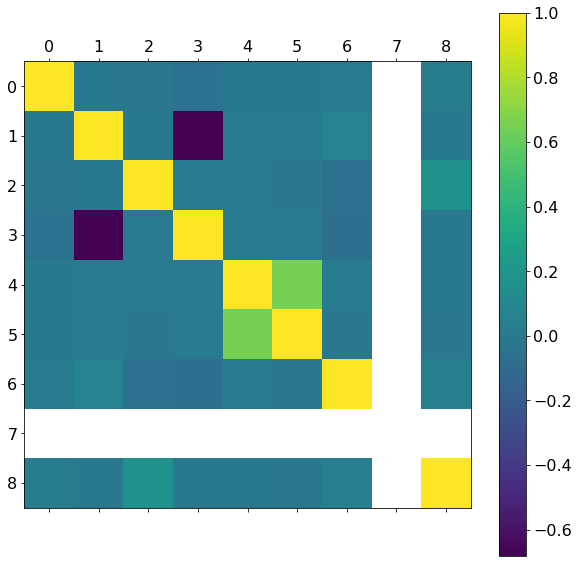

In [108]:
import matplotlib.pyplot as plt
import numpy as np
def plot_corr(df, size=10):
    font={'size':16}
    plt.rc('font',**font)
    corr=df.corr()
    fig, ax = plt.subplots(figsize=(size,size))
    cax=ax.matshow(corr, interpolation='nearest')
    #ax.set_xticks(np.arange(len(corr.columns)))
    #ax.set_xticklabels(corr.columns,rotation=45)
    #ax.set_yticks(np.arange(len(corr.columns)))
    #ax.set_yticklabels(corr.columns)
    fig.colorbar(cax)
    ax.matshow(corr)
    plt.show()

plot_corr(X[X['test']==0])
# It looks like there is a strong correlation between latitude and longitude, can we combine them into a single feature?

## First simple modelling attempt
### Use stochastic gradient descent

In [109]:
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
#Suppress all futurewarnings in console
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

target_cols = ['target_day', 'target_month', 'target_weekday', 'target_year', 'latitude', 'longitude', 'holiday_flg',
              'test','visitors']
X = model_data[target_cols]

target_cols_fit = [col for col in X.columns if not col in ['test','visitors']]
Xsub = X[X['test']==1]
X = X[X['test']==0]

Xsub = Xsub.drop(['test'],axis=1)
X = X.drop(['test'],axis=1)

pipe = Pipeline([('scal',StandardScaler()),
                 ('clf',SGDRegressor())])

X_train, X_test, y_train, y_test = train_test_split(X[target_cols_fit], X['visitors'],test_size=0.25, random_state=42)

parameters = {'clf__alpha': np.logspace(-4,1,6)}
pipe = GridSearchCV(pipe, parameters)

pipe.fit(X_train,y_train)
print(pipe.best_params_)

{'clf__alpha': 0.01}


In [110]:
# Create a table of real vs predicted
testIndices=X_test.index.values
prediction = pd.Series(pipe.predict(X_test), name='Prediction', index=testIndices)
y_test.name='Real'
resultsvsPredictions = pd.concat([prediction, y_test], axis=1)


scores = cross_val_score(pipe,X_test,y_test, scoring='neg_mean_squared_error')
scores_base=cross_val_score(pipe, X_test,pd.Series(np.ones(len(y_test))*y_test.mean()))

print("Trained mean squared error is {:.1f} and untrained is {:.1f}"\
          .format(scores.mean(),scores_base.mean()))

Trained mean squared error is -260.2 and untrained is -34935.6


In [111]:
# Predictions for submission

Xsub['visitors']=pipe.predict(Xsub[target_cols_fit])
SGD_sub=baseline_sub
SGD_sub.visitors = pipe.predict(Xsub[target_cols_fit])
SGD_sub.to_csv('submissions/SGD.csv', index=False)
Xsub.pivot_table(columns='holiday_flg')

holiday_flg,0,1
latitude,35.633756,35.633756
longitude,137.411565,137.411565
target_day,19.057143,10.250000
target_month,4.800000,4.750000
target_weekday,2.857143,3.500000
target_year,2017.000000,2017.000000
visitors,20.292871,25.034302
